Project Introduction: 

In [ ]:
# Cell 1:  load libraries, define data frame
import pandas as pd
import matplotlib.pyplot as plt  # For plotting graphs
import requests  # For making API requests


# Create a list of years from 2014 to 2024
years = list(range(2014, 2025))

# Initialize the dataframe with additional column for Bitcoin value
asset_costs_df = pd.DataFrame({
    'Year': years,
    'Median_Home_Value_USD': [None] * len(years),
    'Median_Income_USD': [None] * len(years),
    'Consumer_Price_Index': [None] * len(years),  # Updated column name
    'Bitcoin_Value_USD': [None] * len(years),  # Add Bitcoin column
    'Home_Price_in_Bitcoin': [None] * len(years)  # Calculate later
})

# Display the updated dataframe
print(asset_costs_df)


In [ ]:
# Cell 2:  define API variables from .env
from dotenv import load_dotenv
import os

# Load environment variables from the .env file
load_dotenv()

# Fetch the API keys
api_key = os.getenv("API_KEY")  # For U.S. Census API
fred_api_key = os.getenv("FRED_API_KEY")  # For FRED API

# Print the API keys to verify
print(f"Census API Key: {api_key}")  # Should output the Census API key or None if there's an issue
print(f"FRED API Key: {fred_api_key}")  # Should output the FRED API key or None if there's an issue


In [ ]:

# Cell 3: fetch data Median_Home_Value_USD via APIs, loop through series of years collecting corresponding data
# Cell 3: fetch data Median_Home_Value_USD via APIs, loop through series of years collecting corresponding data
import requests
from dotenv import load_dotenv
import os

# Load environment variables from the .env file
load_dotenv()

# Fetch the API keys
census_api_key = os.getenv("API_KEY")
fred_api_key = os.getenv("FRED_API_KEY")

# List of years
years_acs5 = list(range(2014, 2023))  # Years for /acs5
years_acs1 = [2023]  # Singular year for /acs1

# Function to fetch data from the Census API
def fetch_census_data(year, url, api_key):
    params = {
        "get": "NAME,B25077_001E",  # Median Home Value (B25077_001E) for the US
        "for": "us:1",  # Geographic identifier for the whole U.S.
        "key": api_key
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        return response.json()[1][1]  # Return the value (the actual data is in the second element)
    else:
        print(f"Error fetching data for year {year}: Status code {response.status_code}")
        return None

# Function to fetch data from the FRED API (S&P/Case-Shiller U.S. National Home Price Index)
def fetch_fred_data(year, fred_api_key):
    series_id = "SPCS20RSA"  # S&P/Case-Shiller U.S. National Home Price Index series ID

    # Correct URL format for FRED API
    url = f"https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={fred_api_key}&file_type=json"
    
    params = {
        "start_date": f"{year}-01-01",  # Start date for the year
        "end_date": f"{year}-12-31",    # End date for the year
    }
    
    response = requests.get(url, params=params)
    
    if response.status_code == 200:
        data = response.json()
        observations = data.get('observations', [])
        
        if observations:
            # Extract the value for the requested year
            value = observations[-1]['value']
            
            # Check if the value is a valid number
            if value != "." and value != "" and value is not None:
                return value  # Return the valid value
            else:
                print(f"Invalid data for year {year}: {value}")
                return None
        else:
            print(f"No data found for year {year}")
            return None
    else:
        print(f"Error fetching FRED data for year {year}: Status code {response.status_code}")
        return None


# Loop through years 2014–2023 using /acs5 and /acs1 endpoints to fetch home value data
for year in years_acs5:
    url = f"https://api.census.gov/data/{year}/acs/acs5"
    home_value = fetch_census_data(year, url, census_api_key)
    if home_value is not None:
        asset_costs_df.loc[asset_costs_df['Year'] == year, 'Median_Home_Value_USD'] = float(home_value)

# Fetch data for 2023 from the /acs1 endpoint (singular year)
year_2023 = 2023
url_2023 = f"https://api.census.gov/data/{year_2023}/acs/acs1"
home_value_2023 = fetch_census_data(year_2023, url_2023, census_api_key)
if home_value_2023 is not None:
    asset_costs_df.loc[asset_costs_df['Year'] == year_2023, 'Median_Home_Value_USD'] = float(home_value_2023)

# For 2024, check if the FRED data is invalid and if so, use 2023's value for 2024
home_value_2024 = fetch_fred_data(2024, fred_api_key)

if home_value_2024 is None or float(home_value_2024) < 50000:  # Assuming a threshold for valid home value
    # Use the value from 2023 if 2024 is invalid or lower than expected
    home_value_2024 = home_value_2023
    asset_costs_df.loc[asset_costs_df['Year'] == 2024, 'Median_Home_Value_USD'] = float(home_value_2024)
else:
    # Update with the valid FRED data if available
    asset_costs_df.loc[asset_costs_df['Year'] == 2024, 'Median_Home_Value_USD'] = float(home_value_2024)

# Display the updated dataframe with the Median Home Value data, including 2024
print(asset_costs_df)


In [ ]:
#Cell 4:  get Median_Income_USD
import requests
from dotenv import load_dotenv
import os

# Load environment variables from the .env file
load_dotenv()

# Fetch the API keys
census_api_key = os.getenv("API_KEY")
fred_api_key = os.getenv("FRED_API_KEY")

# List of years
years_acs5 = list(range(2014, 2023))  # Years for /acs5
years_acs1 = [2023]  # Singular year for /acs1
years_fred = [2024]  # Singular year for FRED

# Function to fetch data from the Census API
def fetch_census_data(year, url, api_key):
    params = {
        "get": "NAME,B19013_001E",  # Median Household Income (B19013_001E)
        "for": "us:1",  # Geographic identifier for the whole U.S.
        "key": api_key
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        return response.json()[1][1]  # Return the value (the actual data is in the second element)
    else:
        print(f"Error fetching data for year {year}: Status code {response.status_code}")
        return None

# Function to fetch data from the FRED API (S&P/Case-Shiller U.S. National Home Price Index)
def fetch_fred_data(year, fred_api_key):
    # Correct URL format for FRED API
    series_id = "SPCS20RSA"  # S&P/Case-Shiller U.S. National Home Price Index series ID

    url = f"https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={fred_api_key}&file_type=json"

    params = {
        "series_id": series_id,
        "api_key": fred_api_key,  # Use the FRED API key
        "file_type": "json",
        "frequency": "a",  # 'a' for annual data
        "start_date": f"{year}-01-01",  # Start date for the year
        "end_date": f"{year}-12-31",  # End date for the year
    }
    
    response = requests.get(url, params=params)
    
    if response.status_code == 200:
        data = response.json()
        observations = data.get('observations', [])
        
        if observations:
            # Extract the value for the requested year
            value = observations[-1]['value']
            
            # Check if the value is a valid number
            if value != "." and value != "" and value is not None:
                return value  # Return the valid value
            else:
                print(f"Invalid data for year {year}: {value}")
                return None
        else:
            print(f"No data found for year {year}")
            return None
    else:
        print(f"Error fetching FRED data for year {year}: Status code {response.status_code}")
        return None


# Loop through years 2014-2022 using /acs5 endpoint for Median Income
for year in years_acs5:
    url = f"https://api.census.gov/data/{year}/acs/acs5"
    income_value = fetch_census_data(year, url, census_api_key)
    if income_value is not None:
        asset_costs_df.loc[asset_costs_df['Year'] == year, 'Median_Income_USD'] = float(income_value)

# Fetch data for 2023 from the /acs1 endpoint for Median Income
year_2023 = 2023
url_2023 = f"https://api.census.gov/data/{year_2023}/acs/acs1"
income_value_2023 = fetch_census_data(year_2023, url_2023, census_api_key)
if income_value_2023 is not None:
    asset_costs_df.loc[asset_costs_df['Year'] == year_2023, 'Median_Income_USD'] = float(income_value_2023)

# Estimate 2024 Median Income using fill-forward based on the 2022-2023 growth rate
if 2023 in asset_costs_df['Year'].values and 2022 in asset_costs_df['Year'].values:
    income_2022 = asset_costs_df.loc[asset_costs_df['Year'] == 2022, 'Median_Income_USD'].values[0]
    income_2023 = asset_costs_df.loc[asset_costs_df['Year'] == 2023, 'Median_Income_USD'].values[0]

    # Calculate the growth rate from 2022 to 2023
    growth_rate = (income_2023 - income_2022) / income_2022

    # Estimate 2024 by applying the growth rate to the 2023 value
    estimated_income_2024 = income_2023 * (1 + growth_rate)

    # Assign the estimated value to the 2024 row
    asset_costs_df.loc[asset_costs_df['Year'] == 2024, 'Median_Income_USD'] = estimated_income_2024

# Display the updated dataframe with both Median Home Value and Median Income
print(asset_costs_df)


In [ ]:
# Cell #5: Get CPI Data and Merge with asset_costs_df

# Import necessary libraries
import requests
import pandas as pd
import json

# Define the API endpoint and headers
url = 'https://api.bls.gov/publicAPI/v1/timeseries/data/'
headers = {'Content-type': 'application/json'}

# Define the data payload to request CPI data (for multiple years)
data = json.dumps({
    "seriesid": ['CUUR0000SA0'],  # Series ID for CPI for All Urban Consumers, All Items, U.S. city average
    "startyear": "2014", 
    "endyear": "2024"
})

# Send the API request
response = requests.post(url, data=data, headers=headers)

# Check for successful response
if response.status_code == 200:
    json_data = response.json()

    # Extract CPI data and organize it into a DataFrame
    cpi_data = []
    for series in json_data['Results']['series']:
        for item in series['data']:
            year = int(item['year'])
            value = float(item['value'])
            cpi_data.append({'Year': year, 'CPI_Value': value})

    cpi_df = pd.DataFrame(cpi_data)
    cpi_df = cpi_df.groupby('Year', as_index=False).agg({'CPI_Value': 'mean'})  # Aggregate by Year
    
    # Forward fill missing values for any missing years
    cpi_df['CPI_Value'] = cpi_df['CPI_Value'].ffill()

    # Check if 2024 exists, and if not, handle it by filling with the last valid value (2023)
    if 2024 not in cpi_df['Year'].values:
        # Create a DataFrame for the missing 2024 year
        new_row = pd.DataFrame({'Year': [2024], 'CPI_Value': [cpi_df['CPI_Value'].iloc[-1]]})
        
        # Concatenate the new row to the original DataFrame
        cpi_df = pd.concat([cpi_df, new_row], ignore_index=True)
    
    # Merge the CPI data into the existing asset_costs_df on 'Year' without redefining the structure
    asset_costs_df = pd.merge(asset_costs_df, cpi_df, on='Year', how='left')

    # Insert CPI_Value data into the existing 'Consumer_Price_Index' column
    asset_costs_df['Consumer_Price_Index'] = asset_costs_df['CPI_Value']

    # Drop the 'CPI_Value' column as it's no longer needed
    asset_costs_df = asset_costs_df.drop(columns=['CPI_Value'])

    # Display the updated DataFrame with CPI values inserted into 'Consumer_Price_Index'
    print(asset_costs_df)

else:
    print(f"Error fetching data from BLS API: Status code {response.status_code}")


In [ ]:
# Cell #6: Fetching Bitcoin data and calculating average value per year
import os
import requests
import pandas as pd
from dotenv import load_dotenv

# Load the API key from the .env file
load_dotenv()
coingecko_api_key = os.getenv("COINGECKO_API_KEY")

# Set up the CoinGecko API URL
url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart?vs_currency=usd&days=max"

# Make the API request without headers (CoinGecko doesn't require API key for this endpoint)
response = requests.get(url)

# Check for successful response
if response.status_code == 200:
    print("API request successful!")

    # Parse the response JSON
    data = response.json()

    # Extract the prices and timestamps
    prices = data['prices']  # This contains a list of [timestamp, price] pairs

    # Convert to a DataFrame for easy processing
    df = pd.DataFrame(prices, columns=['Timestamp', 'Price'])

    # Convert timestamp to year
    df['Year'] = pd.to_datetime(df['Timestamp'], unit='ms').dt.year

    # Calculate the average Bitcoin price per year
    average_prices_per_year = df.groupby('Year')['Price'].mean()

    # Assuming you already have the 'asset_costs_df' DataFrame set up
    # Populate the 'Bitcoin_Value_USD' column with the fetched prices for each year
    asset_costs_df['Bitcoin_Value_USD'] = asset_costs_df['Year'].map(average_prices_per_year)

    # Display the updated DataFrame to confirm the changes
    print(asset_costs_df)
else:
    print("Error fetching data from CoinGecko API:", response.status_code)


In [ ]:
# Cell 7: Calculations for Home_Price_in_Bitcoin

# Ensure that both 'Median_Home_Value_USD' and 'Bitcoin_Value_USD' columns are populated
# Calculate the Home_Price_in_Bitcoin by dividing the home value by the Bitcoin price
asset_costs_df['Home_Price_in_Bitcoin'] = asset_costs_df['Median_Home_Value_USD'] / asset_costs_df['Bitcoin_Value_USD']

# Display the updated dataframe to confirm the calculations
print(asset_costs_df)




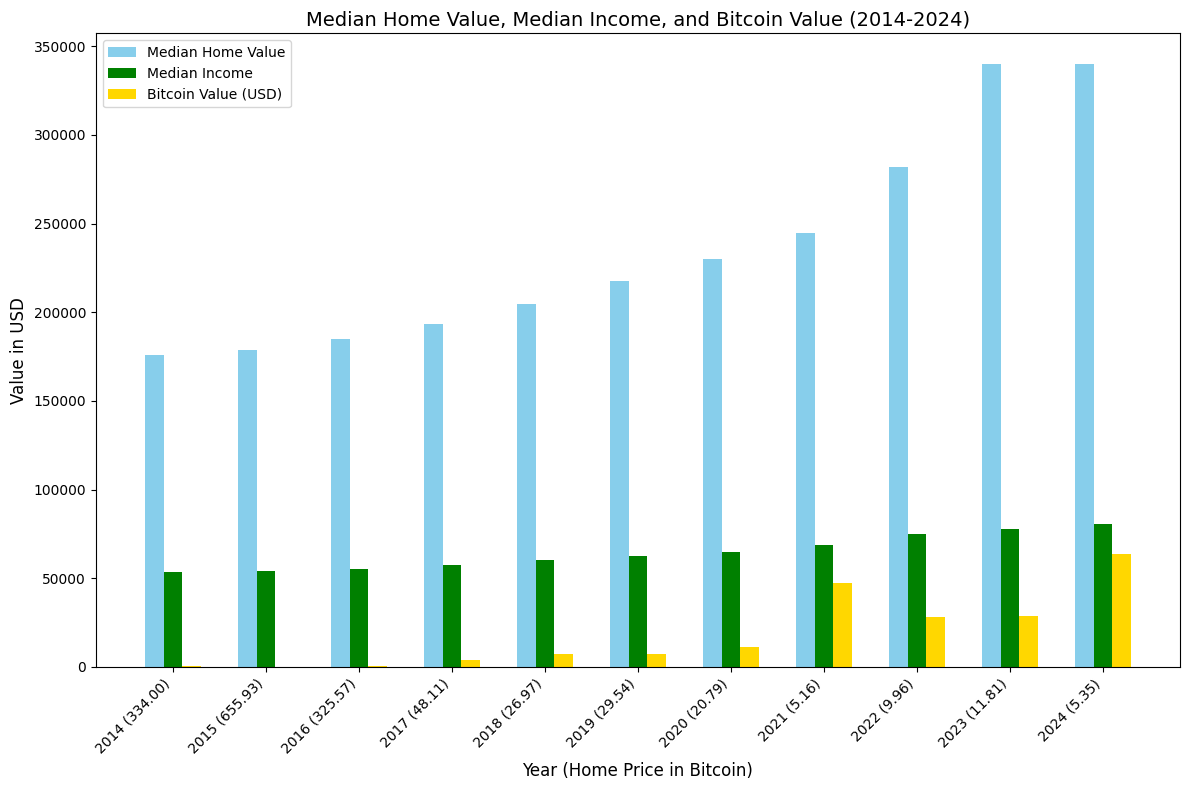

In [37]:
# Cell 8 :  the Bar Graph
import matplotlib.pyplot as plt
import numpy as np

# Create figure and axes
fig, ax1 = plt.subplots(figsize=(12, 8))

# Bar width and positioning
bar_width = 0.2
x = np.arange(len(asset_costs_df['Year']))

# Plot bars for each metric
ax1.bar(x - bar_width, asset_costs_df['Median_Home_Value_USD'], bar_width, label='Median Home Value', color='skyblue')
ax1.bar(x, asset_costs_df['Median_Income_USD'], bar_width, label='Median Income', color='green')
ax1.bar(x + bar_width, asset_costs_df['Bitcoin_Value_USD'], bar_width, label='Bitcoin Value (USD)', color='gold')

# Set x-axis labels with year and appended "Home Price in Bitcoin"
x_labels = [
    f"{year} ({home_price:.2f})"
    for year, home_price in zip(asset_costs_df['Year'], asset_costs_df['Home_Price_in_Bitcoin'])
]
ax1.set_xticks(x)
ax1.set_xticklabels(x_labels, rotation=45, ha='right')

# Add labels, legend, and title
ax1.set_ylabel('Value in USD', fontsize=12)
ax1.set_xlabel('Year (Home Price in Bitcoin)', fontsize=12)
ax1.set_title('Median Home Value, Median Income, and Bitcoin Value (2014-2024)', fontsize=14)
ax1.legend(loc='upper left')

# Increase spacing for the footer to prevent overlap
plt.subplots_adjust(bottom=0.25)

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
# Cell 9:  The line graph
# Line Graph for Asset Costs Comparison
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plotting lines for Median Home Value, Median Income, and Bitcoin Value (in USD)
ax1.plot(asset_costs_df['Year'], asset_costs_df['Median_Home_Value_USD'], label='Median Home Value', color='skyblue', linewidth=2)
ax1.plot(asset_costs_df['Year'], asset_costs_df['Median_Income_USD'], label='Median Income', color='green', linewidth=2)
ax1.plot(asset_costs_df['Year'], asset_costs_df['Bitcoin_Value_USD'], label='Bitcoin Value (USD)', color='gold', linewidth=2)

# Create secondary y-axis for Home Price in Bitcoin
ax2 = ax1.twinx()
ax2.plot(asset_costs_df['Year'], asset_costs_df['Home_Price_in_Bitcoin'], label='Home Price in Bitcoin', color='purple', linewidth=2, linestyle='--')
ax2.set_ylim(0, 700)
ax2.set_ylabel('Home Price in Bitcoin', fontsize=12, color='purple')
ax2.tick_params(axis='y', colors='purple')

# Add labels, legend, and title
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Value in USD', fontsize=12)
ax1.set_title('Asset Costs Comparison (2014-2024)', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Improve layout and display the plot
plt.tight_layout()
plt.show()
